In [43]:
import numpy as np
from tqdm import tqdm
import timeit
from matplotlib import pyplot as plt
from Code import ULA
from Code import Algo1
from Code import ZVnbrosse

### Gaussian mixture 

## $\pi (x) = \frac{1}{2(2\pi)^{d/2}} \left( e ^{\frac{-| x-a|^2}{2}}  + e ^{\frac{-| x+a|^2}{2}} \right), \quad x \in\mathbb R^d$

$U(x) = \frac{1}{2} \|x - a\|_2^2 - \text{log}(1 + e^{-2x^\top a})$

$\nabla U(x) = x-a +2a(1 + e^{2 x^\top a})^{-1}$

$ m = 1 - \|a \|_2^2 \quad $ (strongly convex function)

$M = 1 \quad$  (Lipschitz continuous gradient)

$a = (\frac{1}{\sqrt{2d}}, \dots, \frac{1}{\sqrt{2d}})$

## Setup

In [56]:
dim = 2
h = 0.2
n = 10000
N_train = 10
N_test = 100
deg = 1
def f_grad(x):
    a = np.ones(dim) / np.sqrt(2*dim)
    return x - a + 2 * a/(1 + np.exp(2* (x.T @ a)))

def local_weighted_estimator(X):
    return X.sum(axis=1).mean()

def estimator(XX):
    Pi = np.empty(XX.shape[0])
    for i in tqdm(range(XX.shape[0])):
        Pi[i] = local_weighted_estimator(XX[i])
    return Pi

In [57]:
f_target = 'sum'

### Generate sample and plot

In [58]:
np.random.seed(2342)
X, G, Z = ULA.ULA_with_burnin(d=dim, step=h, burn_in=10000, n=100000,f_grad=f_grad)

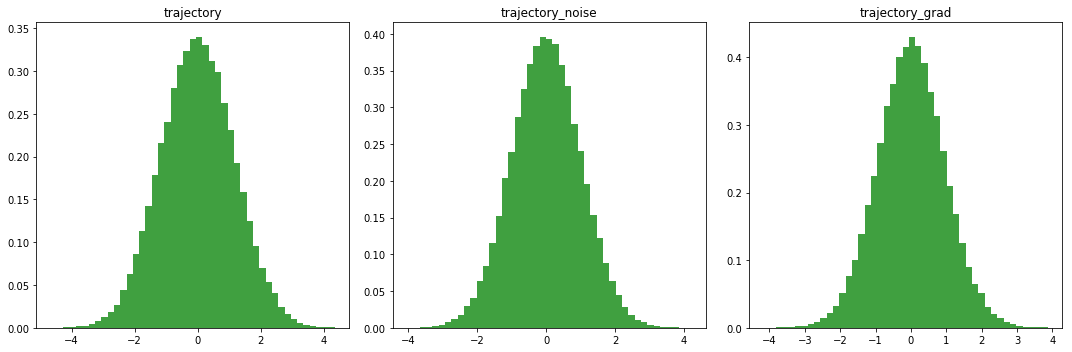

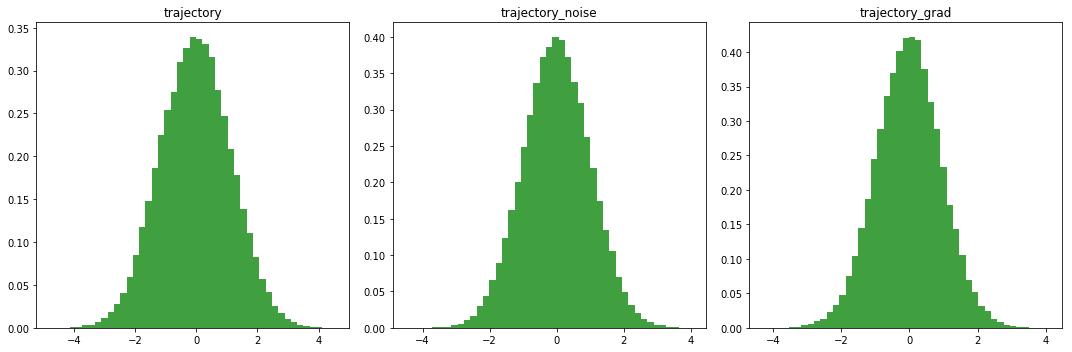

In [59]:
ULA.plot_distr(X,Z,G,0)
ULA.plot_distr(X,Z,G,1)

### Generate train ant test trajectories

In [60]:
np.random.seed(123)

XX, GG, ZZ = ULA.generate_train_trajectories(X, N_train=N_train,d = dim, step = h, n = n, f_grad=f_grad)
XX_test, GG_test, ZZ_test = ULA.generate_test_trajetories(N_test=N_test, d =dim, step=h, 
                                                          burn_in=10000, n = n, f_grad=f_grad)

### Algorithm 1 

In [61]:
Betas, degrees = Algo1.G_pml_fit_mean(XX,f_target, max_deg = deg)

100%|██████████| 2000/2000 [01:10<00:00, 28.29it/s] 


In [62]:
k_comb = np.zeros((dim,dim), dtype=np.int16)
for i in range(dim):
    k_comb[i,i] = 1

In [63]:
# k_comb = np.array([[1,0], [0,1], [1,1], [2,0], [0,2]], dtype=np.int16)

### Check and time

In [64]:
i_test = 5
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[i_test])
print ("mean of target function =", p)
for i in range(len(k_comb)):
    p = p - Algo1.M_bias(k_comb[i],XX_test[i_test],GG_test[i_test], ZZ_test[i_test], h, degrees,Betas,50)
    print ("            (k = {}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))

mean of target function = 0.17375240113247467
            (k = [1 0]) = 0.15055160086193684 [Time:25.2349093889934]
            (k = [0 1]) = 0.0001654578538788365 [Time:50.34150317800231]


## Check results on test trajectories

In [65]:
P_test = estimator(XX_test)

100%|██████████| 100/100 [00:00<00:00, 12965.79it/s]


In [66]:
res_zv_1 = []
for i in range (XX_test.shape[0]):
    res_zv_1.append(ZVnbrosse.ZVpolyOne(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_zv_1 = np.array(res_zv_1).reshape(-1)

res_zv_2 = []
for i in range (XX_test.shape[0]):
    res_zv_2.append(ZVnbrosse.ZVpolyTwo(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_zv_2 = np.array(res_zv_2).reshape(-1)

res_cv_1 = []
for i in range (XX_test.shape[0]):
    res_cv_1.append(ZVnbrosse.CVpolyOne(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_cv_1 = np.array(res_cv_1).reshape(-1)

res_cv_2 = []
for i in range (XX_test.shape[0]):
    res_cv_2.append(ZVnbrosse.CVpolyTwo(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_cv_2 = np.array(res_cv_2).reshape(-1)

In [67]:
def save_plot(M_test, n_tilde):
    all_data = [P_test]
    all_data.append(P_test - M_test.sum(axis = 0))
    all_data.append(res_zv_1)
    all_data.append(res_cv_1)
        
    plt.figure(figsize=(10,10))
    plt.violinplot(all_data, showmeans=True, showmedians=False)
    plt.xticks(np.arange(1,5), ('O', 'CV_B', 'ZV', 'CV'))
    plt.tick_params(labelsize = 15)
    plt.grid()
    plt.savefig("Algo1_logs/GM_{}d_violin_(h = {}, n = {}, K = 1, n_tilde={}, f_target = {}).png".format(dim, h, n, n_tilde,f_target))

    all_data.append(res_zv_2)
    all_data.append(res_cv_2)
    plt.figure(figsize=(10,10))
    plt.violinplot(all_data, showmeans=True, showmedians=False)
    plt.xticks(np.arange(1,7), ('O', 'CV_B', 'ZV-1', 'CV-1', 'ZV-2', 'CV-2'))
    plt.tick_params(labelsize = 15)
    plt.grid()
    plt.savefig("Algo1_logs/GM_{}d_violin_full_(h = {}, n = {}, K = 1, n_tilde={}, f_target = {}).png".format(dim, h, n, n_tilde,f_target))

plots_saved for n_tilde = 10
plots_saved for n_tilde = 20
plots_saved for n_tilde = 30
plots_saved for n_tilde = 50
plots_saved for n_tilde = 70


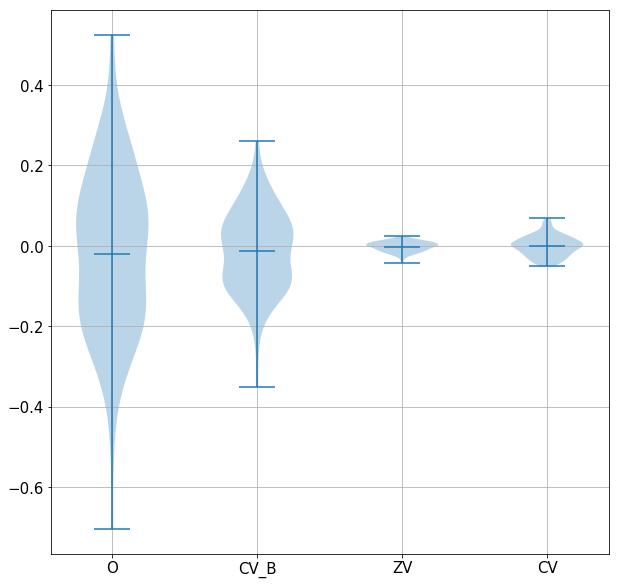

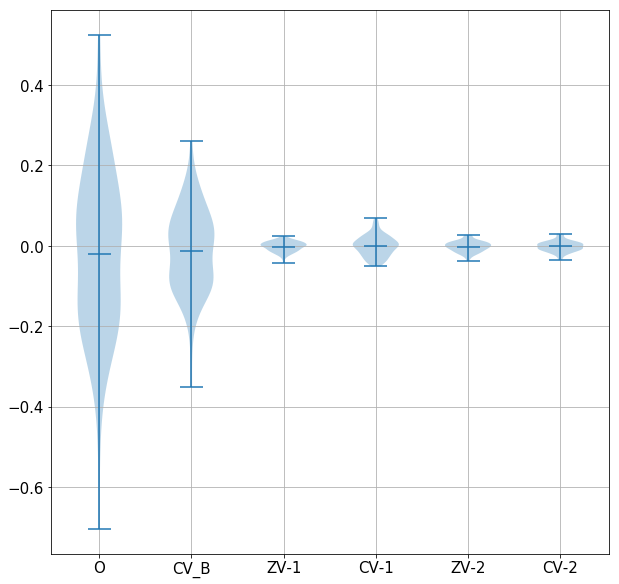

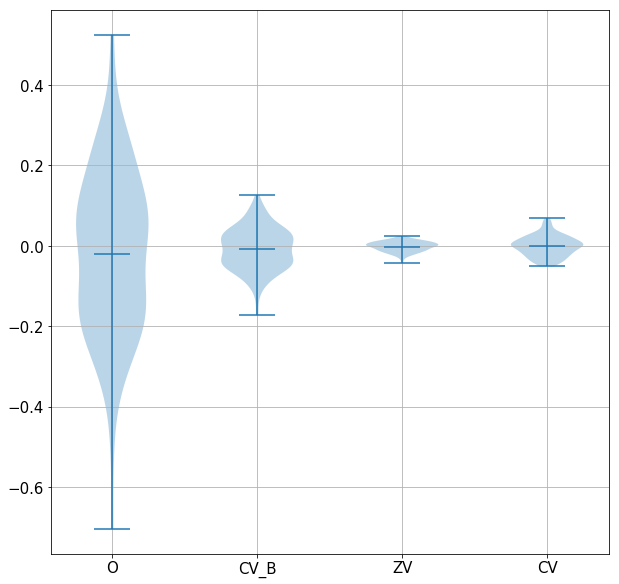

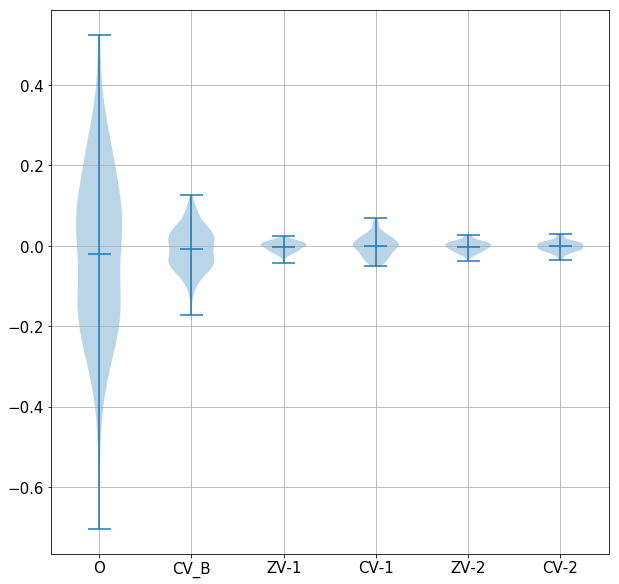

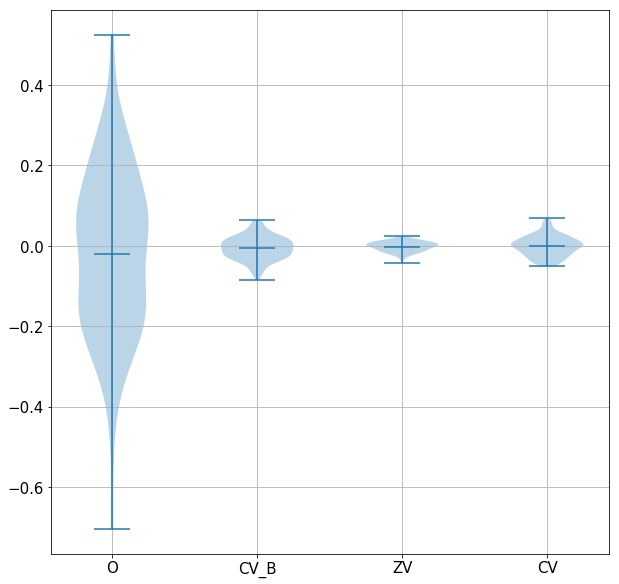

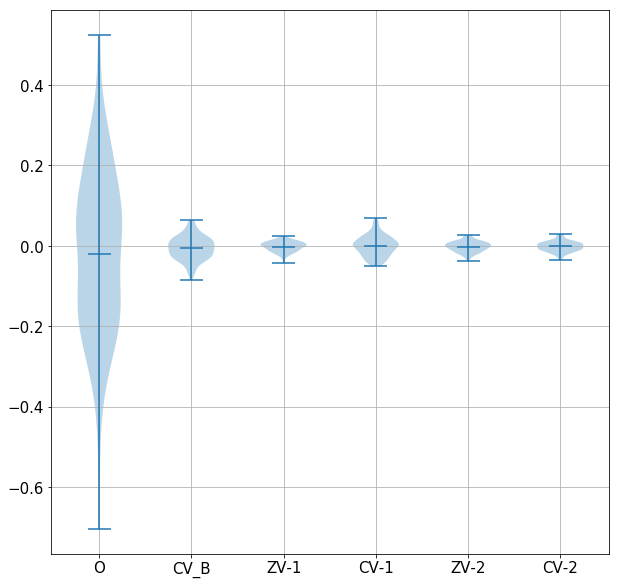

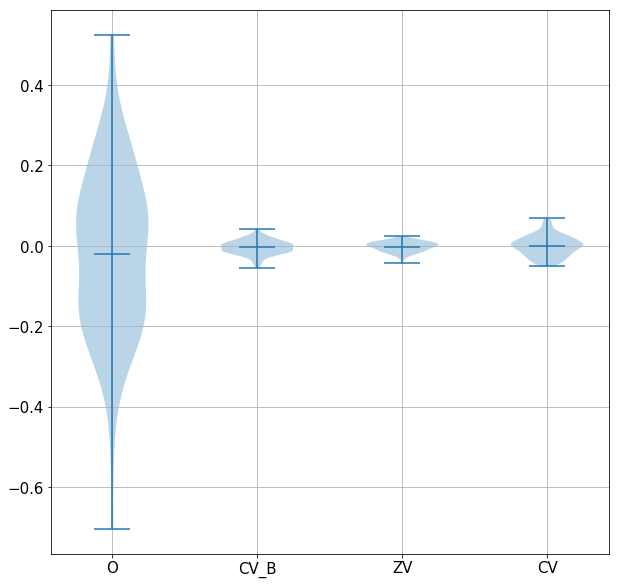

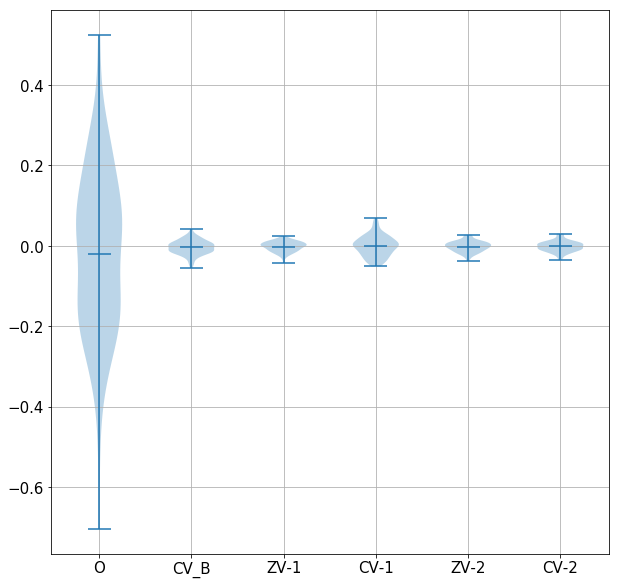

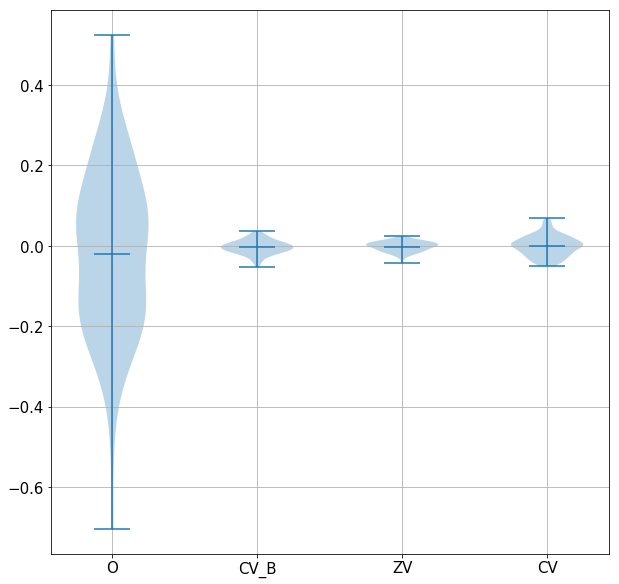

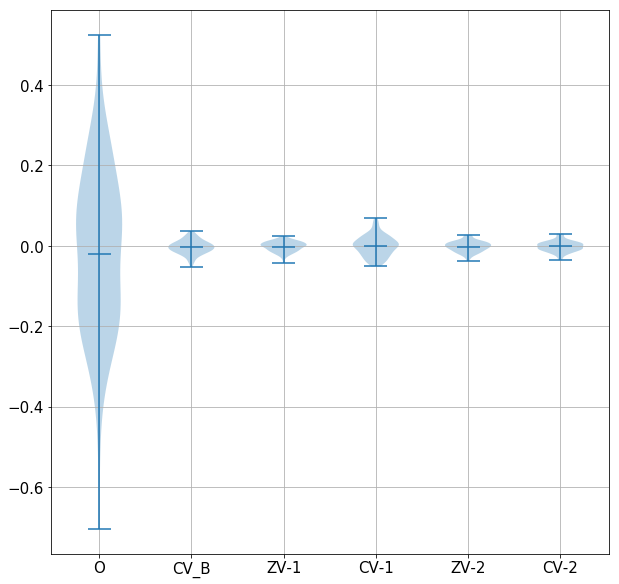

In [68]:
for n_tilde in [30, 50, 70]:
    M_test = np.empty((len(k_comb),P_test.shape[0]))
    for i in range(len(k_comb)):
        M_test[i] = Algo1.estimator_bias(k_comb[i], XX_test, GG_test, ZZ_test, h, degrees,Betas, n_tilde, n_jobs=3)
    save_plot(M_test, n_tilde)
    np.save("Algo1_logs/GM_{}d_M_test(h = {}, n = {}, K = 1, n_tilde={}, f_target = {}).npy".
            format(dim, h, n, n_tilde,f_target), M_test)
    print("plots_saved for n_tilde = {}".format(n_tilde))

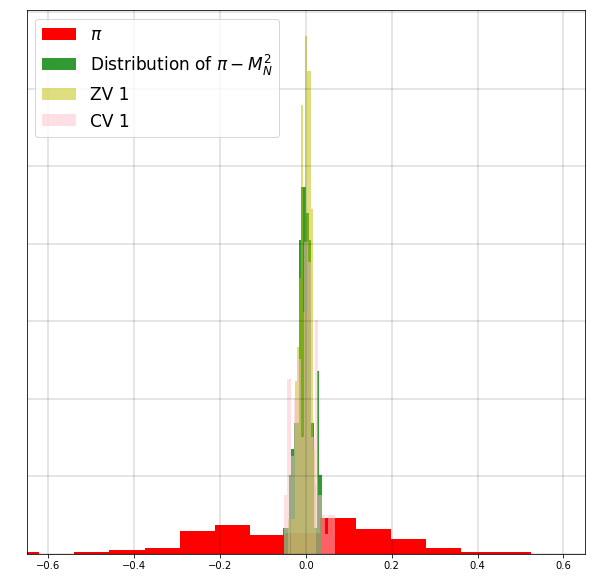

In [71]:
plt.figure(figsize=(10,10))
plt.hist(P_test,15, facecolor='r', density=True, alpha=1, label=r"$\pi$")

plt.hist((P_test-M_test.sum(axis=0)),15, density=True, facecolor='g', alpha=0.8, label="Distribution of $\pi - M^2_N$")

plt.hist(res_zv_1,15, facecolor='y', density=True, alpha=0.5, label="ZV 1")
# plt.hist(res_zv_2,15, facecolor='b', density=True, alpha=0.5, label="ZV 2")
plt.hist(res_cv_1,15, facecolor='pink', density=True, alpha=0.5, label="CV 1")
# plt.hist(res_cv_2,15, facecolor='black', density=True, alpha=0.5, label="CV 2")

plt.legend(loc=2, prop={'size': 17})
plt.grid(linestyle='-', linewidth=0.2, color='black')
plt.tick_params(axis='y',color = 'w', labelcolor = 'w', which='both')
plt.xlim(-0.65, 0.65)
plt.show()

In [1]:
all_data = []
all_data.append(P_test - M_test.sum(axis = 0))
all_data.append(res_zv_1)
# all_data.append(res_zv_2)
all_data.append(res_cv_1)
# all_data.append(res_cv_2)
    
plt.figure(figsize=(10,10))
plt.violinplot(all_data, showmeans=True, showmedians=False)
# plt.title('violin plot')
plt.xticks(np.arange(1,5), ('pi', 'CV_B', 'ZV_1', 'CV_1'))
plt.grid()
plt.show()

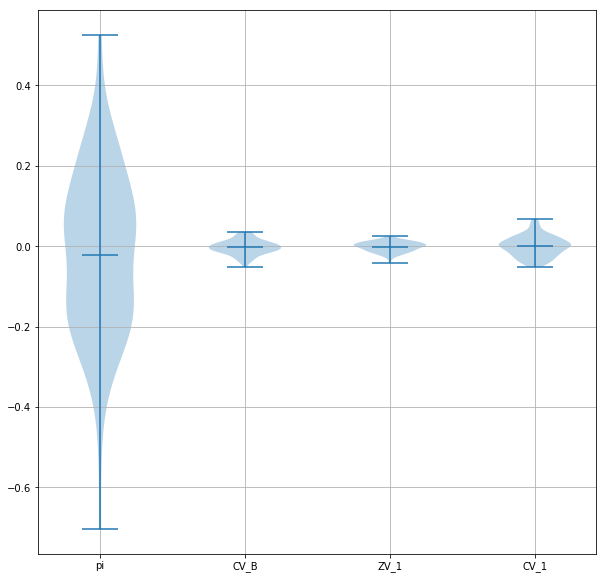

In [73]:
all_data = [P_test]
all_data.append(P_test - M_test.sum(axis = 0))
all_data.append(res_zv_1)
# all_data.append(res_zv_2)
all_data.append(res_cv_1)
# all_data.append(res_cv_2)
    
plt.figure(figsize=(10,10))
plt.violinplot(all_data, showmeans=True, showmedians=False)
# plt.title('violin plot')
plt.xticks(np.arange(1,5), ('pi', 'CV_B', 'ZV_1', 'CV_1'))
plt.grid()
plt.show()

In [74]:
print ('          Variance of Pi = ',P_test.var(ddof = 1))
for i in range(len(k_comb)):
    print ('Variance of new estimator =',(P_test-M_test[:i+1].sum(axis = 0)).var(ddof = 1))
print ('        Variance of CV 1 = ',res_cv_1.var(ddof=1))
print ('        Variance of CV 2 = ',res_cv_2.var(ddof=1))
print ('        Variance of ZV 1 = ',res_zv_1.var(ddof=1))
print ('        Variance of ZV 2 = ',res_zv_2.var(ddof=1))

          Variance of Pi =  0.04246542758291
Variance of new estimator = 0.02338442567747864
Variance of new estimator = 0.00032835879747579303
        Variance of CV 1 =  0.0006516529879252916
        Variance of CV 2 =  0.00017645180027654522
        Variance of ZV 1 =  0.00015899978851968984
        Variance of ZV 2 =  0.00017829878927398476


In [75]:
print ('VRF CVB = ',P_test.var(ddof = 1)/ (P_test - M_test.sum(axis = 0)).var(ddof=1))
print ('VRF CV1 = ',P_test.var(ddof = 1)/res_cv_1.var(ddof = 1))
print ('VRF CV2 = ',P_test.var(ddof = 1)/res_cv_2.var(ddof = 1))
print ('VRF ZV1 = ',P_test.var(ddof = 1)/res_zv_1.var(ddof = 1))
print ('VRF ZV2 = ',P_test.var(ddof = 1)/res_zv_2.var(ddof = 1))

VRF CVB =  129.32629766388578
VRF CV1 =  65.16570685589863
VRF CV2 =  240.66304518489346
VRF ZV1 =  267.0785161305499
VRF ZV2 =  238.17002771485477
